In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

/home/mrjohn/.conda/envs/mathML/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X[:10000]
y = y[:10000]
X.shape

(10000, 784)

In [5]:
X /= 255.0

In [6]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

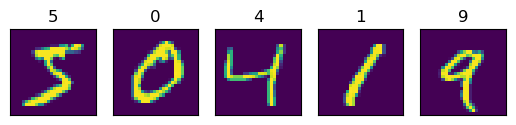

In [7]:
plot_example(X, y)

In [8]:
%%timeit -n 1 -r 1

# These are separate try/except blocks so that if the QR decomposition succeeds
# but the SVD fails, we don't have to recompute the QR decomposition.
# try:
#     Q = np.load('Q.npy')
#     R = np.load('R.npy')
# except OSError:
Q, R = linalg.qr(X)
np.save('Q.npy', Q)
np.save('R.npy', R)

# try:
#     U = np.load('U.npy')
#     s = np.load('s.npy')
#     Vh = np.load('Vh.npy')
# except OSError:
U, s, Vh = linalg.svd(R)
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vh.npy', Vh)

32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# Only have to run this once, the svd is very slow for such a big matrix
# Save the results and set load=True to load them
load = True

if load:
    U = np.load('U.npy')
    s = np.load('s.npy')
    Vh = np.load('Vh.npy')
else:
    U, s, Vh = linalg.svd(X)

In [10]:
U.shape, s.shape, Vh.shape

((10000, 10000), (784,), (784, 784))

In [11]:
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vh.npy', Vh)

Text(0.5, 1.0, 'Singular Values')

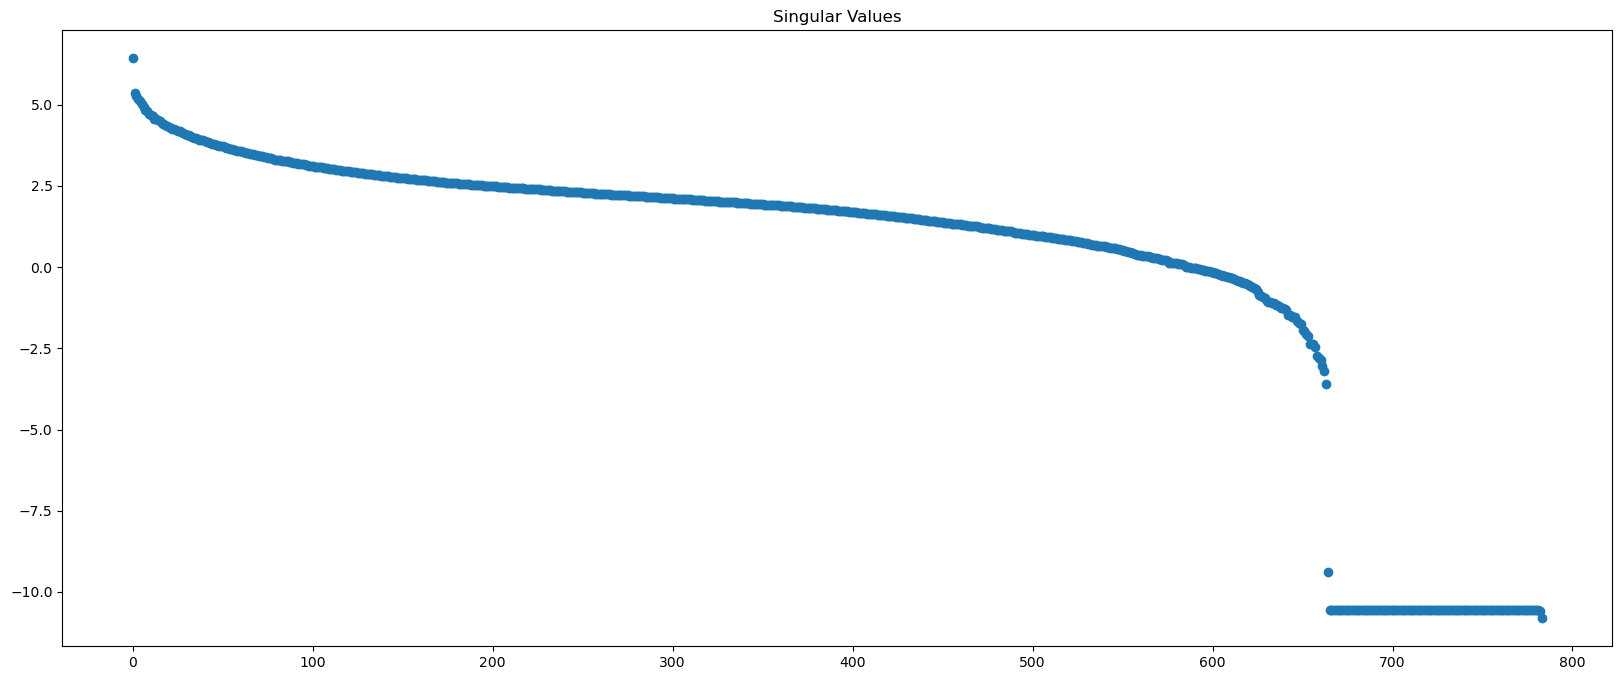

In [12]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s))
plt.title('Singular Values')

## Translation
- Find center of the bounding box
- Translate the bounding box center to the image center
- Add translation vector to dimensions
- SVD 

In [ ]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

10000it [00:01, 6461.18it/s]


7 27 8 21
(17, 14)
recentered shape (28, 28)


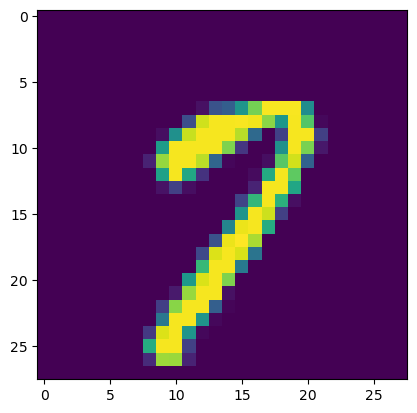

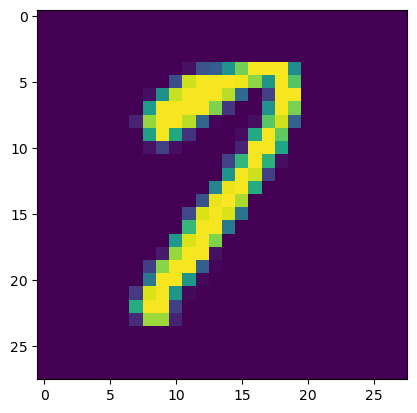

In [75]:
from tqdm import tqdm

X_recentered = np.zeros_like(X)

for i, img in tqdm(enumerate(X)):
    img = img.reshape(28,28)
    rmin, rmax, cmin, cmax = find_bbox(img)
    bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
    
    bbox_img = img[rmin:rmax, cmin:cmax]

    padr1 = padr2 = (28-(rmax-rmin))//2
    padc1 = padc2 = (28-(cmax-cmin))//2

    if (rmax+rmin)%2 == 1:
        padr2 += 1
    if (cmax+cmin)%2 == 1:
        padc2 += 1

    recentered_img = np.pad(bbox_img, ((padr1, padr2), (padc1, padc2)))
    X_recentered[i] = recentered_img.flatten()

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(recentered_img)

print(rmin, rmax, cmin, cmax)
print(bbox_center)
print('recentered shape', recentered_img.shape)

In [76]:
Q_rec, R_rec = linalg.qr(X_recentered)
U_rec, s_rec, Vh_rec = linalg.svd(R_rec)

s_rec.shape

(784,)

Text(0.5, 1.0, 'Singular Values After Recentering')

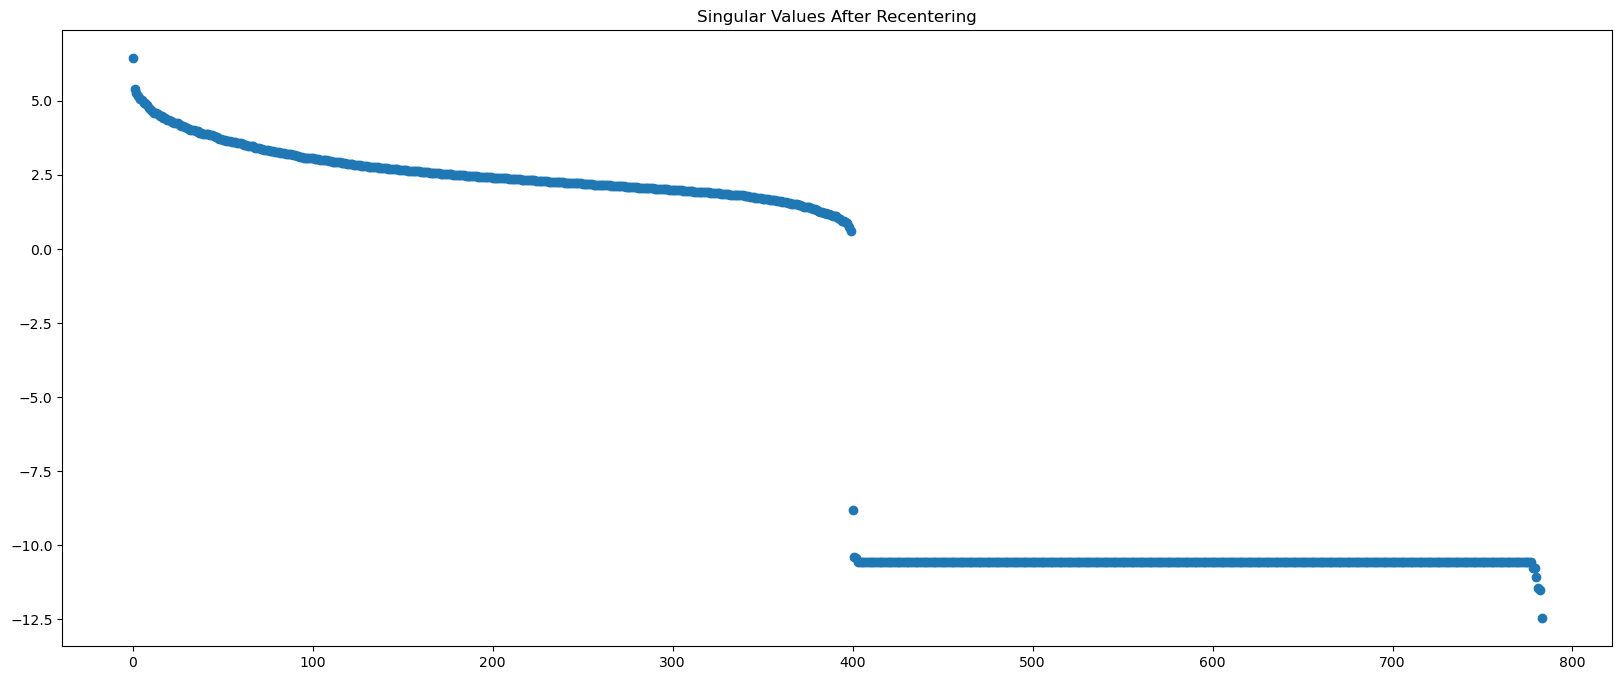

In [77]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s_rec))
plt.title('Singular Values After Recentering')

## Split by class

In [ ]:
digits = {}
si_list = []

for i in range(10):
    digits[i] = X[y==i]

In [ ]:
for i in range(10):
    print(digits[i].shape)
    Qi, Ri = linalg.qr(digits[i])
    Ui, si, Vhi = linalg.svd(Ri)
    si_list.append(si)

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(10,30))

for i in range(10):
    ax[i].scatter(np.arange(0,784), np.log(si_list[i]))
    ax[i].set_title(f'Singular Values for Class [i]')

## Nonlinear transformation

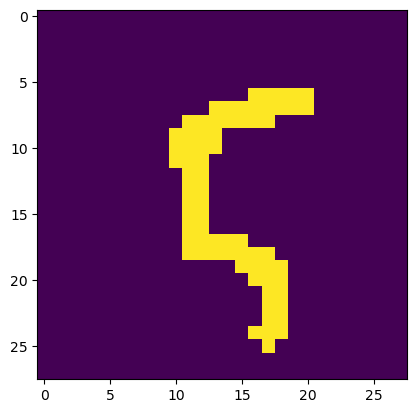

In [36]:
X2 = (X>0.5).astype(np.float32)
plt.imshow(X2[100].reshape(28,28))

In [43]:
Q2, R2 = linalg.qr(X2)
U2, s2, Vh2 = linalg.svd(R2)

In [44]:
s2.shape

(784,)

Text(0.5, 1.0, 'Singular Values')

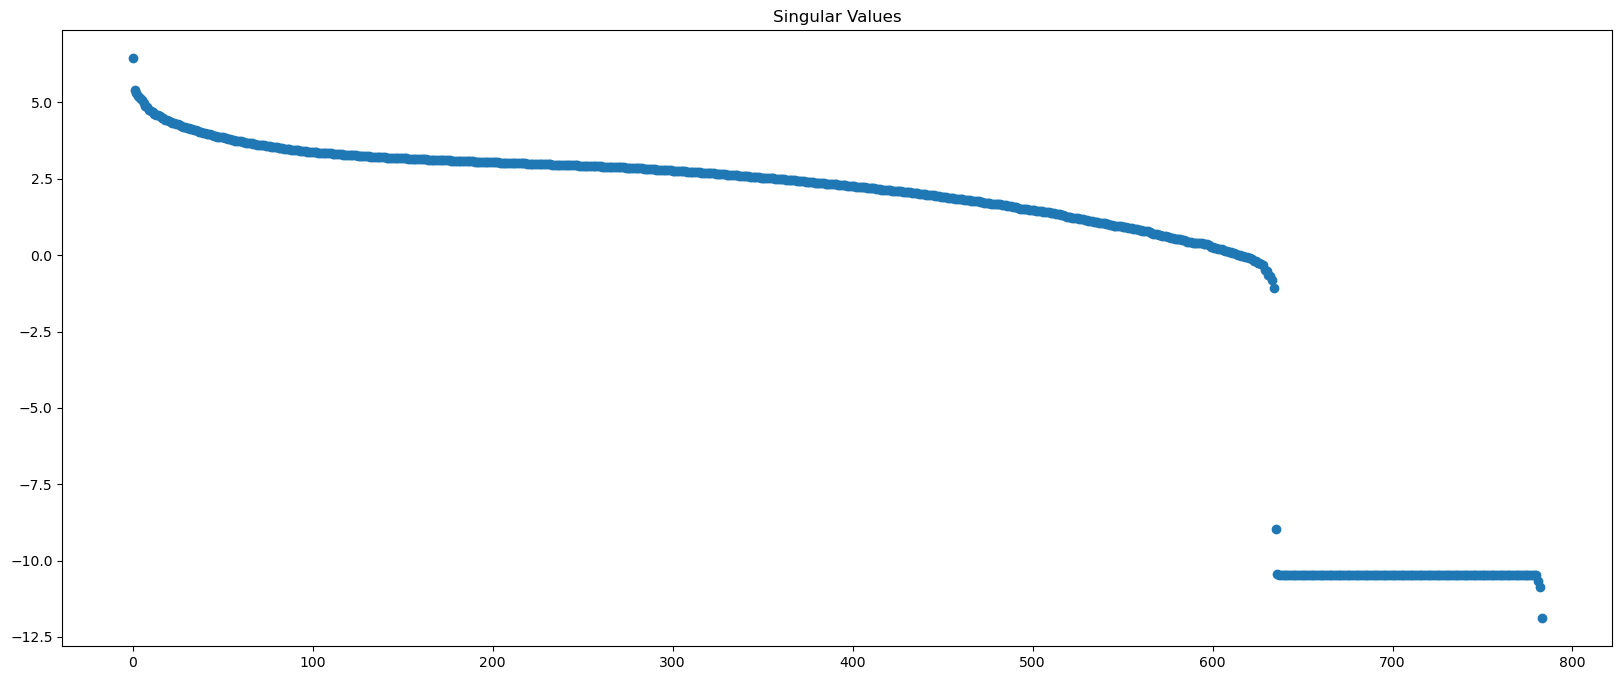

In [45]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s2))
plt.title('Singular Values After X -> {1, X>0.5; 0 otherwise}')